## k-Nearest Neighbors

In [2]:
import math                                                 # basic calculations like square root
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn import metrics                                 # measures to check our models
from sklearn.model_selection import cross_val_score         # cross validation methods
import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call
from sklearn.model_selection import train_test_split        # train and test split

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression

In [3]:
#taken from SubsurfaceDataAnalytics_kNearestNeighbour.ipynb (https://github.com/GeostatsGuy)
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
#modified slightly to reflect whethere it's testing or training data when printing mean quared error    
def check_model(model,xfeature,yfeature,response,title,data):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on',str(data),':' ,round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

In [4]:
data = pd.read_csv('unconv_MV_v5.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [5]:
#standardize the variables for feature selection
scaler = StandardScaler()                                   # instantiate the scaler 
sdata = scaler.fit_transform(data)              # standardize all the values extracted from the DataFrame 
data_st = pd.DataFrame()                                     # instantiate a new DataFrame
data_st = pd.DataFrame(sdata, index=data.index, columns=data.columns) # copy the standardized values into the new DataFrame
data_st.describe()  

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,-6.661338e-18,2.620126e-16,-5.662137e-17,3.985701e-16,1.824929e-16,3.552714e-16,9.126033e-16,1.776357e-16
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.723412e+00,-2.848142e+00,-1.853701e+00,-2.986650e+00,-2.640962e+00,-2.457313e+00,-3.446814e+00,-2.227345e+00
25%,-8.617060e-01,-7.013606e-01,-6.997528e-01,-7.451372e-01,-7.383912e-01,-7.763606e-01,-6.475066e-01,-7.004716e-01
50%,0.000000e+00,2.660490e-02,-1.712823e-01,-2.449306e-02,9.564649e-02,8.233024e-02,-1.432979e-02,-2.681256e-02
75%,8.617060e-01,8.136175e-01,5.540977e-01,6.652032e-01,7.166516e-01,7.484661e-01,5.938532e-01,7.830487e-01
max,1.723412e+00,2.887855e+00,3.208033e+00,2.937664e+00,2.566186e+00,2.476256e+00,3.018254e+00,2.376222e+00


In [6]:
#mutual information
mutual_information = mutual_info_regression(data_st.iloc[:,1:7],data_st.iloc[0:200,7])
print(mutual_information)

[0.93421218 0.43227038 0.04018924 0.07522715 0.23264042 0.07378973]


Based on the mutual information coefficients, I'm going to use porosity and permeability (the highest coefficients, position 0 and 1) to predict production

In [7]:
features = data[["Por",'Perm']]
features.head()

,Por,Perm
0,12.08,2.92
1,12.38,3.53
2,14.02,2.59
3,17.67,6.75
4,17.52,4.57


I'm going to restandardize these values to do k-nearest neighbors. This will allow me to transform just these back to non-standard values later.

In [8]:
sfeatures = scaler.fit_transform(features)              # standardize all the values extracted from the DataFrame 
features_st = pd.DataFrame(sfeatures, index=features.index, columns=features.columns) # copy the standardized values into the new DataFrame
features_st.describe()

,Por,Perm
count,2.000000e+02,2.000000e+02
mean,2.620126e-16,-5.662137e-17
std,1.002509e+00,1.002509e+00
min,-2.848142e+00,-1.853701e+00
25%,-7.013606e-01,-6.997528e-01
50%,2.660490e-02,-1.712823e-01
75%,8.136175e-01,5.540977e-01
max,2.887855e+00,3.208033e+00


Creating the training and testing datasets with a 80/20 split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features_st, data["Prod"], random_state = 876, test_size=0.20)
y_train = pd.DataFrame({'Prod':y_train.values})
y_test = pd.DataFrame({'Prod':y_test.values})

Taking a look at the training and testing data to see how sparsely sampled the data is

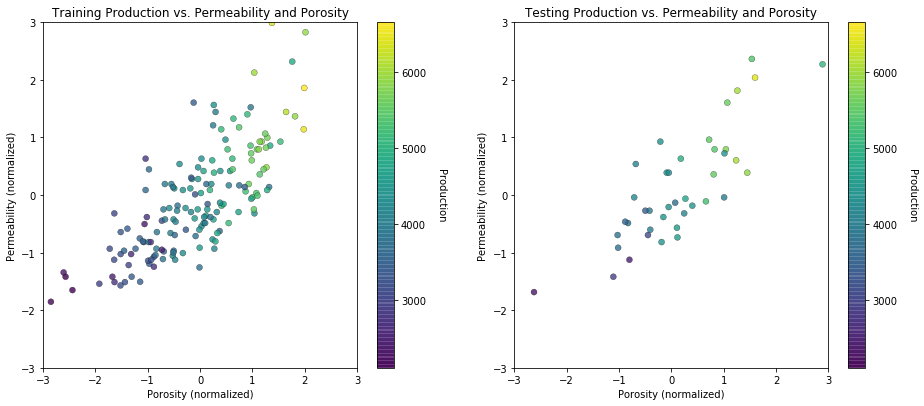

In [38]:
prodmin = np.min(data['Prod']); prodmax = np.max(data["Prod"])

plt.subplot(121)
im = plt.scatter(X_train["Por"],X_train["Perm"],s=None, c=y_train['Prod'], marker=None, cmap=None, norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training Production vs. Permeability and Porosity'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Permeability (normalized)')
plt.xlim(-3,3); plt.ylim(-3,3)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test["Por"],X_test["Perm"],s=None, c=y_test['Prod'], marker=None, cmap=None, norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Production vs. Permeability and Porosity'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Permeability (normalized)')
plt.xlim(-3,3); plt.ylim(-3,3)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The data looks fairly well sampled in the feature-space. Will now initiate k-nearest neighbors

In [56]:
kneigh = KNeighborsRegressor(weights = 'uniform', n_neighbors=12, p = 1)

Making and plotting the model from the training data, then applying to the testing data and plotting again

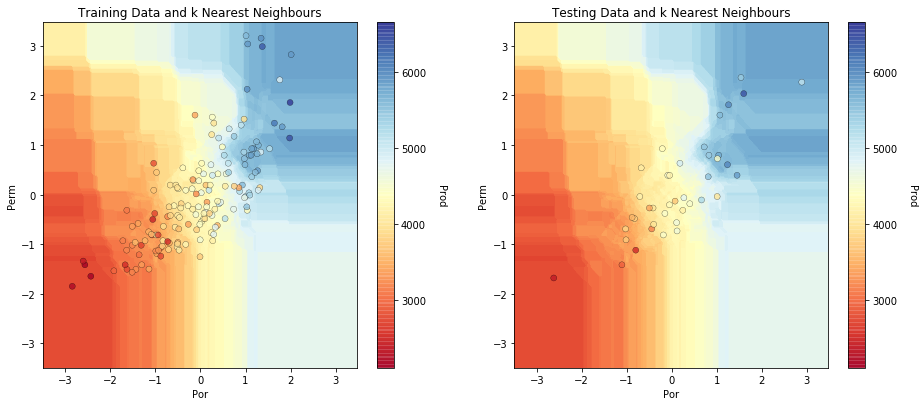

In [62]:
kneigh_fit = kneigh.fit(X_train,y_train['Prod'])              # train the model with the training data


plt.subplot(121)
visualize_model(kneigh_fit,X_train["Por"],-3.5,3.5,X_train["Perm"],-3.5,3.5,y_train["Prod"],prodmin,prodmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(kneigh_fit,X_test["Por"],-3.5,3.5,X_test["Perm"],-3.5,3.5,y_test["Prod"],prodmin,prodmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Model performed fairly well on the testing data -- none of the colors are wildly off

Comparing the actual vs predicted production:

Mean Squared Error on Training : 226376.19 , Variance Explained = 0.77 Cor = 0.88
Mean Squared Error on Testing : 204117.21 , Variance Explained = 0.78 Cor = 0.88


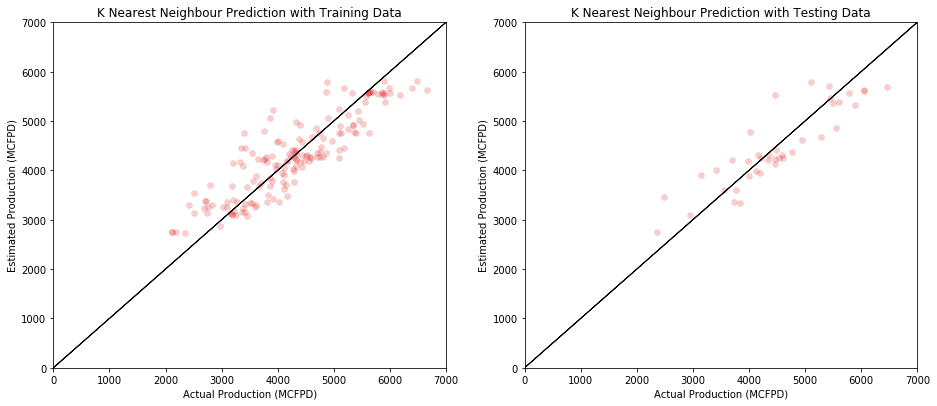

In [58]:
plt.subplot(121)
check_model(kneigh_fit,X_train["Por"],X_train["Perm"],y_train["Prod"],'K Nearest Neighbour Prediction with Training Data',data='Training')

plt.subplot(122)
check_model(kneigh_fit,X_test["Por"],X_test["Perm"],y_test["Prod"],'K Nearest Neighbour Prediction with Testing Data',data='Testing')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()



At this point, I need to tune the hyperparameter, k, as well as the weighting style (inverse distance or arthemetric mean)to figure out what best minimizes the mean squared error (with this randomly-seeded training/testing split of the data) to see how the model performs. I'll do this with 50 different k values, 1-50, for each weight-type.

In [59]:
#modified from SubsurfaceDataAnalytics_kNearestNeighbour.ipynb (https://github.com/GeostatsGuy)
k = 1
dist_error = []
unif_error = []
k_mat = np.linspace(1,50,50)
while k <= 50:
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    neigh_dist_fit = neigh_dist.fit(X_train,y_train['Prod'])    # train the model with the training data
    y_pred = neigh_dist_fit.predict(X_test)
    MSE = metrics.mean_squared_error(y_test,y_pred)
    dist_error.append(MSE)
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 1)
    neigh_unif_fit = neigh_unif.fit(X_train,y_train['Prod'])    # train the model with the training data
    y_pred = neigh_unif_fit.predict(X_test)
    MSE = metrics.mean_squared_error(y_test,y_pred)
    unif_error.append(MSE)
    k = k + 1

I'll now plot this to visualize, and to print the minimum mean squared error and k-value that produces this MSE value for both distance (inverse distance weighting) and uniform (arithmetric average)

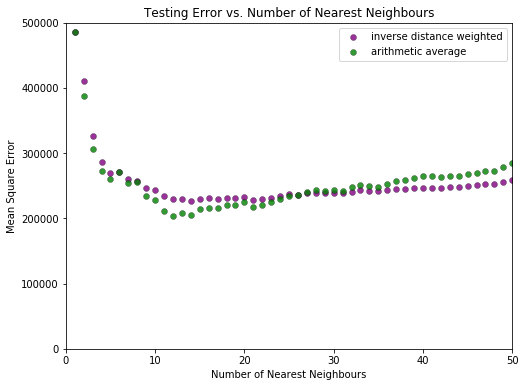

min MSE for distance: 227333.8 , k to produce minimum MSE for distance: 14
min MSE for uniform: 204117.2 , k to produce minimum MSE for uniform: 12


In [61]:
#modified from SubsurfaceDataAnalytics_kNearestNeighbour.ipynb (https://github.com/GeostatsGuy)
plt.figure(figsize=(8,6))
plt.scatter(k_mat,dist_error,s=None, c='purple',label = 'inverse distance weighted', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='green',label = 'arithmetic average', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Error vs. Number of Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.legend()
plt.xlim(0,50); plt.ylim(0,500000)
plt.show()

import operator
dist_min_index, dist_min_value = min(enumerate(dist_error), key=operator.itemgetter(1))
unif_min_index, unif_min_value = min(enumerate(unif_error), key=operator.itemgetter(1))

print('min MSE for distance:',str(round(dist_min_value,1)),', k to produce minimum MSE for distance:',str(dist_min_index + 1))
print('min MSE for uniform:',str(round(unif_min_value,1)),', k to produce minimum MSE for uniform:',str(unif_min_index + 1))

## Executive Summary
The challenge was to create a model to predict production based on two most important features. This was done by using k-nearest neighbors for prediction with variable hyperparameter values and weights. Using a random seed equal to 876, the results included a suite of mean squared error values for different k values and weighting values (distance or uniform). Based on the minimum mean squared error for this random seed, I recommend using k=12 and uniform (arithmetic average) weighting for this model.